In [1]:
from nilearn.glm.first_level import spm_hrf
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
from nilearn.glm.first_level import make_first_level_design_matrix
import pandas as pd

/Users/zeynepenkavi/.pyenv/versions/3.8.3/envs/py-dvl-fmri/lib/python3.8/site-packages/nilearn/glm/__init__.py:55: FutureWarning: The nilearn.glm module is experimental. It may change in any future release of Nilearn.
  warn('The nilearn.glm module is experimental. '


Variable length stimulus

A 'modulation' column was found in the given events data and is used.


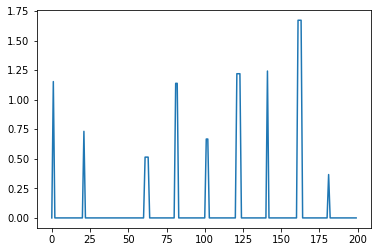

In [4]:
tr = 1.0
nscans = 200
frame_times = np.arange(nscans) * tr
onsets = np.arange(0, nscans, 20)
durations = np.random.normal(loc=2, scale=1, size=10)
amplitudes = np.random.normal(loc=1, scale=.5, size=10)

events = pd.DataFrame({'onset': onsets, 'duration': durations, 'trial_type': 'stim', 'modulation': amplitudes})

design_matrix = make_first_level_design_matrix(frame_times,
                                               events,
                                               drift_model=None,
                                               hrf_model=None)
plt.plot(design_matrix['stim'])

This stimulus can induce different responses

- Node responds for longer duration to longer stimulus
- Node responds with higher amplitude to longer stimulus
- Node responds with both a higher amplitude and longer duration
- Node responds with a delay to longer stimulus

What do these look like at node level and at the measurable HDR level?

A 'modulation' column was found in the given events data and is used.
A 'modulation' column was found in the given events data and is used.


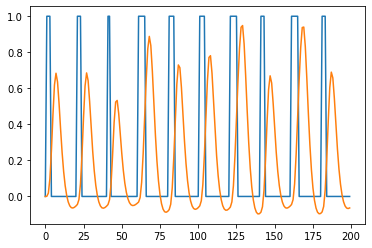

In [5]:
node1 = pd.DataFrame({'onset': onsets, 'duration': durations+2, 'trial_type': 'node1', 'modulation': 1})
node1_conv = make_first_level_design_matrix(frame_times,
                                               node1,
                                               drift_model=None,
                                               hrf_model='spm')
node1 = make_first_level_design_matrix(frame_times,
                                               node1,
                                               drift_model=None,
                                               hrf_model=None)
plt.plot(node1['node1'])
plt.plot(node1_conv['node1'])

A 'modulation' column was found in the given events data and is used.
A 'modulation' column was found in the given events data and is used.


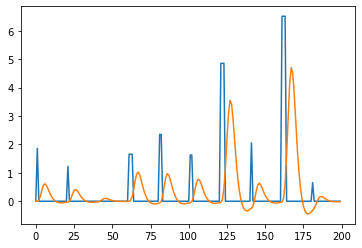

In [6]:
node2 = pd.DataFrame({'onset': onsets, 'duration': durations, 'trial_type': 'node2', 'modulation': amplitudes*durations})
node2_conv = make_first_level_design_matrix(frame_times,
                                               node2,
                                               drift_model=None,
                                               hrf_model='spm')
node2 = make_first_level_design_matrix(frame_times,
                                               node2,
                                               drift_model=None,
                                               hrf_model=None)

plt.plot(node2['node2'])
plt.plot(node2_conv['node2'])

A 'modulation' column was found in the given events data and is used.
A 'modulation' column was found in the given events data and is used.


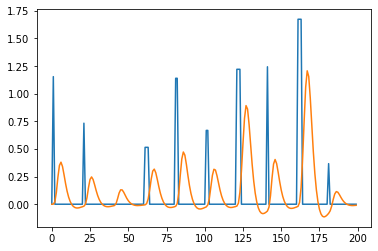

In [8]:
node3 = pd.DataFrame({'onset': onsets, 'duration': durations, 'trial_type': 'node3', 'modulation': amplitudes})
node3_conv = make_first_level_design_matrix(frame_times,
                                               node3,
                                               drift_model=None,
                                               hrf_model='spm')
node3 = make_first_level_design_matrix(frame_times,
                                               node3,
                                               drift_model=None,
                                               hrf_model=None)

plt.plot(node3['node3'])
plt.plot(node3_conv['node3'])

A 'modulation' column was found in the given events data and is used.
A 'modulation' column was found in the given events data and is used.


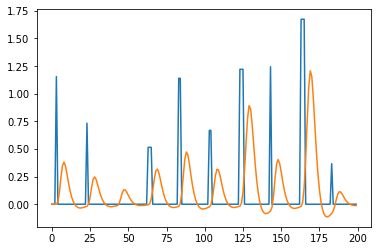

In [9]:
node4 = pd.DataFrame({'onset': onsets+2, 'duration': durations, 'trial_type': 'node4', 'modulation': amplitudes})
node4_conv = make_first_level_design_matrix(frame_times,
                                               node4,
                                               drift_model=None,
                                               hrf_model='spm')
node4 = make_first_level_design_matrix(frame_times,
                                               node4,
                                               drift_model=None,
                                               hrf_model=None)

plt.plot(node4['node4'])
plt.plot(node4_conv['node4'])